In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import joblib
from collections import Counter

# NLTK downloads
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\oltih2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\oltih2\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\oltih2\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
df = pd.read_csv(r"C:\Users\oltih2\Downloads\Hotel_Reviews.csv")
print("Dataset Shape:", df.shape)
print("Columns:", df.columns)

# Keep only the relevant columns
df = df[['Positive_Review', 'Negative_Review', 'Reviewer_Score']]

Dataset Shape: (515738, 17)
Columns: Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
       'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
       'Negative_Review', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews', 'Positive_Review',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Tags',
       'days_since_review', 'lat', 'lng'],
      dtype='object')


In [3]:
df['Sentiment'] = df['Reviewer_Score'].apply(lambda x: 'positive' if x >= 8 else 'negative')
df['Text'] = df['Positive_Review'] + " " + df['Negative_Review']
df['Text'] = df['Text'].str.replace('No Positive', '').str.replace('No Negative', '').str.strip()

print(df[['Text', 'Sentiment']].head())
print("Sentiment counts:", df['Sentiment'].value_counts())

                                                Text Sentiment
0  Only the park outside of the hotel was beautif...  negative
1  No real complaints the hotel was great great l...  negative
2  Location was good and staff were ok It is cute...  negative
3  Great location in nice surroundings the bar an...  negative
4  Amazing location and building Romantic setting...  negative
Sentiment counts: Sentiment
positive    335646
negative    180092
Name: count, dtype: int64


In [4]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(words)

df['clean_text'] = df['Text'].apply(preprocess)

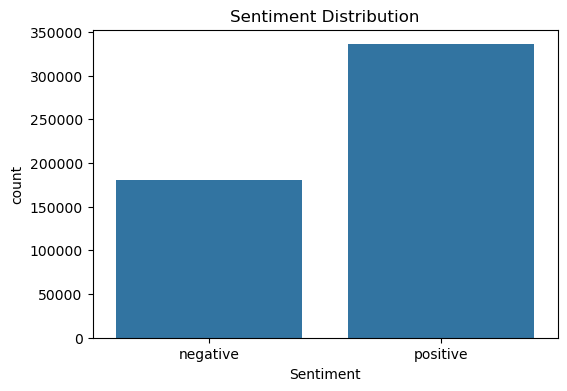

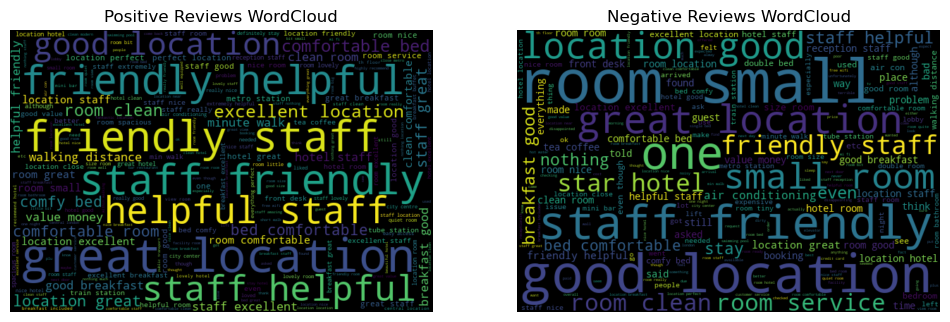

Most common words: [('room', 391988), ('staff', 236613), ('hotel', 210527), ('location', 204787), ('breakfast', 145598), ('good', 133264), ('great', 115626), ('bed', 102028), ('friendly', 89992), ('helpful', 80567), ('nice', 79344), ('clean', 75465), ('comfortable', 65486), ('excellent', 64629), ('small', 61547), ('would', 50471), ('stay', 50062), ('service', 48031), ('bathroom', 46943), ('nothing', 45441)]


In [5]:
# Sentiment distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Sentiment', data=df)
plt.title("Sentiment Distribution")
plt.show()

# Word clouds
positive_text = ' '.join(df[df['Sentiment']=='positive']['clean_text'])
negative_text = ' '.join(df[df['Sentiment']=='negative']['clean_text'])

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
WordCloud(width=600, height=400, background_color='white').generate(positive_text)
plt.imshow(WordCloud(width=600, height=400).generate(positive_text), interpolation='bilinear')
plt.axis('off')
plt.title("Positive Reviews WordCloud")

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=600, height=400).generate(negative_text), interpolation='bilinear')
plt.axis('off')
plt.title("Negative Reviews WordCloud")
plt.show()

# Most common words
all_words = ' '.join(df['clean_text']).split()
most_common_words = Counter(all_words).most_common(20)
print("Most common words:", most_common_words)

In [6]:
X = df['clean_text']
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

# Use a smaller sample for training to speed up
sample_size = 50000  # 50k samples instead of 412k
X_train_small = X_train[:sample_size]
y_train_small = y_train[:sample_size]

# Logistic Regression
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train_tfidf[:sample_size], y_train_small)

# Multinomial Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf[:sample_size], y_train_small)

# Optional: skip MLP or reduce its size to avoid long training
mlp_model = MLPClassifier(hidden_layer_sizes=(50,), max_iter=100)
mlp_model.fit(X_train_tfidf[:sample_size], y_train_small)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(50,), max_iter=100)

=== Logistic Regression ===
Accuracy: 0.7798600069802614
              precision    recall  f1-score   support

    negative       0.72      0.61      0.66     36165
    positive       0.80      0.87      0.84     66983

    accuracy                           0.78    103148
   macro avg       0.76      0.74      0.75    103148
weighted avg       0.78      0.78      0.78    103148



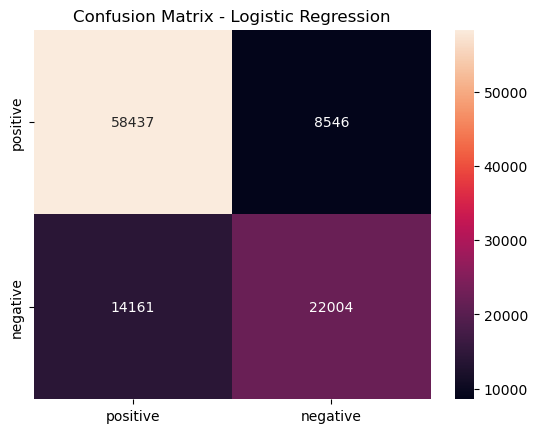

=== Naive Bayes ===
Accuracy: 0.7659964323108543
              precision    recall  f1-score   support

    negative       0.75      0.50      0.60     36165
    positive       0.77      0.91      0.83     66983

    accuracy                           0.77    103148
   macro avg       0.76      0.70      0.72    103148
weighted avg       0.76      0.77      0.75    103148



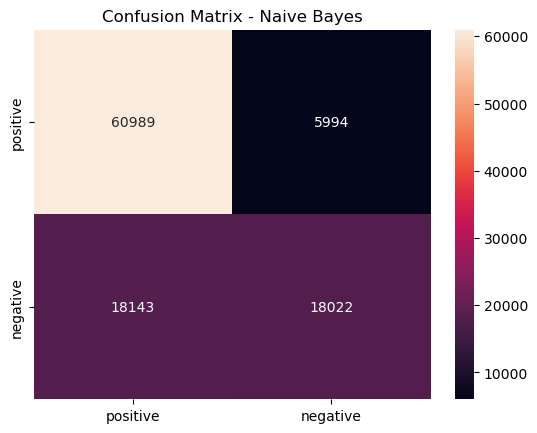

=== MLP Neural Network ===
Accuracy: 0.7409547446387714
              precision    recall  f1-score   support

    negative       0.64      0.59      0.62     36165
    positive       0.79      0.82      0.80     66983

    accuracy                           0.74    103148
   macro avg       0.72      0.71      0.71    103148
weighted avg       0.74      0.74      0.74    103148



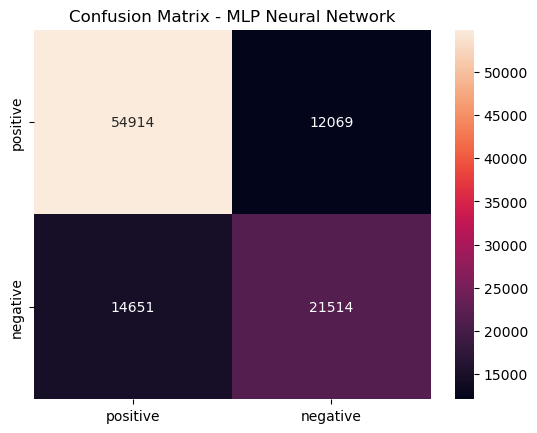

In [8]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    print(f"=== {model_name} ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred, labels=['positive','negative'])
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=['positive','negative'], yticklabels=['positive','negative'])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()
    return y_pred

y_pred_logreg = evaluate_model(logreg_model, X_test_tfidf, y_test, "Logistic Regression")
y_pred_nb = evaluate_model(nb_model, X_test_tfidf, y_test, "Naive Bayes")
y_pred_mlp = evaluate_model(mlp_model, X_test_tfidf, y_test, "MLP Neural Network")

In [9]:
def predict_sentiment(text, model=logreg_model):
    text_clean = preprocess(text)
    vect = vectorizer.transform([text_clean])
    return model.predict(vect)[0]

# Test
sample_review = "The hotel was beautiful, the staff was very friendly and helpful."
print("Sample Review Prediction:", predict_sentiment(sample_review))

Sample Review Prediction: positive


In [10]:
joblib.dump(logreg_model, 'logreg_hotel_model.pkl')
joblib.dump(nb_model, 'nb_hotel_model.pkl')
joblib.dump(mlp_model, 'mlp_hotel_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']